# Analysis of NFL Games
#### Thomas Barton and Mia Bennett

## Introduction

Since the start of the football over a century ago, the way a game is played has dramatically changed. Historically, games had less rules, there weren't as many teams in the league, and most teams rushed the ball. While the forward pass was allowed in the NFL playbook, no teams actually threw the ball to pass, meaning the game was mainly a rushing game. However, teams started passing the ball in the early 20th century, and since then, the sport has become a mainly passing game. The league is constantly changing, and the style of each team is always evolving, so with this project, we want to see what the determining characteristics of a football game are in the 21st century. 

Using NFL game stats from all games played between the 2002 and 2019 season, this tutorial will analyze the various factors (both offensive and defensive) that contribute to the outcome of a game, and determine the most important factors that predict the outcome of a game using machine learning. For NFL fans, we hope to provide some interesting insights that they may have not known, as well as some more intuition on how to determine if a team will win. This tutorial simply calculates scoring and win predictions, and is not responsible for any ill placed bets or money lost.  

## Importing Libraries
We will be using Python3 and several imported libraries: Pandas, Numpy, Seaborn, scikit-learn, and more. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

## Reading the Data

The data collected in this CSV came from scraping ESPN. A Reddit user compiled the dataset, and the link to the original post is below. Every row in the table corresponds to a game played between the 2002-2019 NFL season. 

 [Reddit Link](https://www.reddit.com/r/datasets/comments/djucb6/nfl_game_stats_scraped_from_espn/)

The original CSV has columns for the date, away and home team. The following 18 columns are repeated for both home and away team: first downs, third downs, fourth downs, passing yards, rushing yards, total yards, completetion, sacks, rushing attemps, fumbles, interceptions, turnovers, penalties, redzone drives, drives, defense stopping touchdowns, time of posession, and score. 


In [2]:
data = pd.read_csv('nfl_dataset.csv') 
data.head()

,date,away,home,first_downs_away,first_downs_home,third_downs_away,third_downs_home,fourth_downs_away,fourth_downs_home,passing_yards_away,passing_yards_home,rushing_yards_away,rushing_yards_home,total_yards_away,total_yards_home,comp_att_away,comp_att_home,sacks_away,sacks_home,rushing_attempts_away,rushing_attempts_home,fumbles_away,fumbles_home,int_away,int_home,turnovers_away,turnovers_home,penalties_away,penalties_home,redzone_away,redzone_home,drives_away,drives_home,def_st_td_away,def_st_td_home,possession_away,possession_home,score_away,score_home
0,2002-09-05,49ers,Giants,13,21,4-12,9-16,0-0,0-1,166,318,113,43,279,361,16-26,28-45,0-0,3-24,25,22,0,0,1,3,1,3,5-29,10-80,0-8,0-6,13,15,0,0,27:32,32:28,16,13
1,2002-09-08,Jets,Bills,18,26,2-8,7-17,0-0,2-2,193,242,73,142,266,384,24-30,26-39,3-17,4-29,14,32,1,1,0,2,1,3,10-90,10-82,0-9,0-8,17,18,2,0,21:06,39:08,37,31
2,2002-09-08,Vikings,Bears,19,20,5-13,7-13,0-0,0-0,228,288,140,80,368,368,16-28,20-33,1-6,1-9,33,26,1,1,2,1,3,2,8-52,4-33,0-7,0-6,17,17,0,0,31:31,28:29,23,27
3,2002-09-08,Chargers,Bengals,27,13,6-10,4-11,0-0,0-0,160,167,241,36,401,203,15-19,18-31,1-0,4-31,45,13,0,0,0,1,0,1,4-39,9-57,0-7,0-5,11,15,0,0,37:48,22:12,34,6
4,2002-09-08,Chiefs,Browns,24,24,5-11,4-11,0-0,0-0,276,352,194,59,470,411,20-29,28-40,0-0,1-7,30,20,0,1,1,0,1,1,9-87,4-38,0-10,0-10,20,17,0,0,30:16,29:44,40,39


## Data Manipulation

From the first five entries in the dataset displayed above, each individual entry contains statistics of a game for both home and away teams. To better organize and understand individual team stats, a new dataframe is created that stores the stats for each team for each game. The home and away statistics are broken up into two rows, rather than storing all of the information on one row, as it was before. This new organizational structure will allow us to get a better understanding of each team's performance across the seasons.

In [3]:
# We are first converting the time of posession column, which is in the format, minutes:seconds into seconds so we can 
# easily compare them
data['top_away'] = ((data['possession_away'].str.extract('(\d+):', expand=False)).astype(int)*60) \
+ (data['possession_away'].str.extract(':(\d+)', expand=False)).astype(int)
data['top_home'] = ((data['possession_home'].str.extract('(\d+):', expand=False)).astype(int)*60) \
+ (data['possession_home'].str.extract(':(\d+)', expand=False)).astype(int)

In [4]:
# Creating a new Pandas DataFrame with the desired columns
team_df = pd.DataFrame(columns=['date','team', 'home_or_away', 'first_downs', 'third_downs','fourth_downs', 
                                'passing_yards', 'rushing_yards', 'total_yards', 'completions', 'sacks', 
                                'rushing_attempts', 'fumbles', 'interceptions', 'turnovers', 'penalties', 'redzone', 
                                'drives', 'def_st_td', 'possession', 
                                'score', 'win', 'win_pct'])
# Iterating though every row in the original DataFrame and adding two rows to the new DataFrame for the home and
# away teams
for index, column in data.iterrows():
  team_df = team_df.append({'date': column['date'], 'team': column['home'], 'home_or_away': 1, 
                            'first_downs': column['first_downs_home'], 'third_downs': column['third_downs_home'], 
                            'fourth_downs': column['fourth_downs_home'],'passing_yards': column['passing_yards_home'], 
                            'rushing_yards': column['rushing_yards_home'], 'total_yards': column['total_yards_home'], 
                            'completions': column['comp_att_home'], 'sacks': column['sacks_home'], 
                            'rushing_attempts': column['rushing_attempts_home'], 'fumbles': column['fumbles_home'], 
                            'interceptions': column['int_home'], 'turnovers': column['turnovers_home'], 
                            'penalties': column['penalties_home'], 'redzone': column['redzone_home'], 
                            'drives': column['drives_home'], 'def_st_td': column['def_st_td_home'], 
                            'possession': column['top_home'], 'score': column['score_home'], 
                            'win': 'W' if column['score_home'] > column['score_away'] else 'L' 
                            if column['score_home'] < column['score_away'] else 'T', 'win_pct': 1 
                            if column['score_home'] > column['score_away'] else 0}, ignore_index=True)
  team_df = team_df.append({'date': column['date'], 'team': column['away'], 'home_or_away': 0, 
                            'first_downs': column['first_downs_away'], 'third_downs': column['third_downs_away'], 
                            'fourth_downs': column['fourth_downs_away'],'passing_yards': column['passing_yards_away'],
                            'rushing_yards': column['rushing_yards_away'], 'total_yards': column['total_yards_away'], 
                            'completions': column['comp_att_away'], 'sacks': column['sacks_away'], 
                            'rushing_attempts': column['rushing_attempts_away'], 'fumbles': column['fumbles_away'], 
                            'interceptions': column['int_away'], 'turnovers': column['turnovers_away'], 
                            'penalties': column['penalties_away'], 'redzone': column['redzone_away'], 
                            'drives': column['drives_away'], 'def_st_td': column['def_st_td_away'],
                            'possession': column['top_away'], 'score': column['score_away'], 
                            'win': 'L' if column['score_home'] >  column['score_away'] else 'W' 
                            if column['score_home'] < column['score_away']  else 'T', 'win_pct': 1 
                            if column['score_away'] > column['score_home'] else 0}, ignore_index=True)
team_df.head()

,date,team,home_or_away,first_downs,third_downs,fourth_downs,passing_yards,rushing_yards,total_yards,completions,sacks,rushing_attempts,fumbles,interceptions,turnovers,penalties,redzone,drives,def_st_td,possession,score,win,win_pct
0,2002-09-05,Giants,1,21,9-16,0-1,318,43,361,28-45,3-24,22,0,3,3,10-80,0-6,15,0,1948,13,L,0
1,2002-09-05,49ers,0,13,4-12,0-0,166,113,279,16-26,0-0,25,0,1,1,5-29,0-8,13,0,1652,16,W,1
2,2002-09-08,Bills,1,26,7-17,2-2,242,142,384,26-39,4-29,32,1,2,3,10-82,0-8,18,0,2348,31,L,0
3,2002-09-08,Jets,0,18,2-8,0-0,193,73,266,24-30,3-17,14,1,0,1,10-90,0-9,17,2,1266,37,W,1
4,2002-09-08,Bears,1,20,7-13,0-0,288,80,368,20-33,1-9,26,1,1,2,4-33,0-6,17,0,1709,27,W,1


Next, we must convert the data that is currently stored as a string and turn it into a numeric type so that further statistical analysis can be conducted. 

In [5]:
team_df['passing_yards'] = team_df['passing_yards'].apply(pd.to_numeric)
team_df['first_downs'] = team_df['first_downs'].apply(pd.to_numeric)
team_df['rushing_yards'] = team_df['rushing_yards'].apply(pd.to_numeric)
team_df['total_yards'] = team_df['total_yards'].apply(pd.to_numeric)
team_df['rushing_attempts'] = team_df['rushing_attempts'].apply(pd.to_numeric)
team_df['fumbles'] = team_df['fumbles'].apply(pd.to_numeric)
team_df['interceptions'] = team_df['interceptions'].apply(pd.to_numeric)
team_df['turnovers'] = team_df['turnovers'].apply(pd.to_numeric)
team_df['drives'] = team_df['drives'].apply(pd.to_numeric)
team_df['def_st_td'] = team_df['def_st_td'].apply(pd.to_numeric)
team_df['possession'] = team_df['possession'].apply(pd.to_numeric)
team_df['score'] = team_df['score'].apply(pd.to_numeric)
team_df['win_pct'] = team_df['win_pct'].apply(pd.to_numeric)



## Exploratory Data Analysis: Looking at Individual Teams
Looking at which statistics win or lose games

First, we will compare each team's total passing and rushing yards to see which offensive method each team utilizes more.

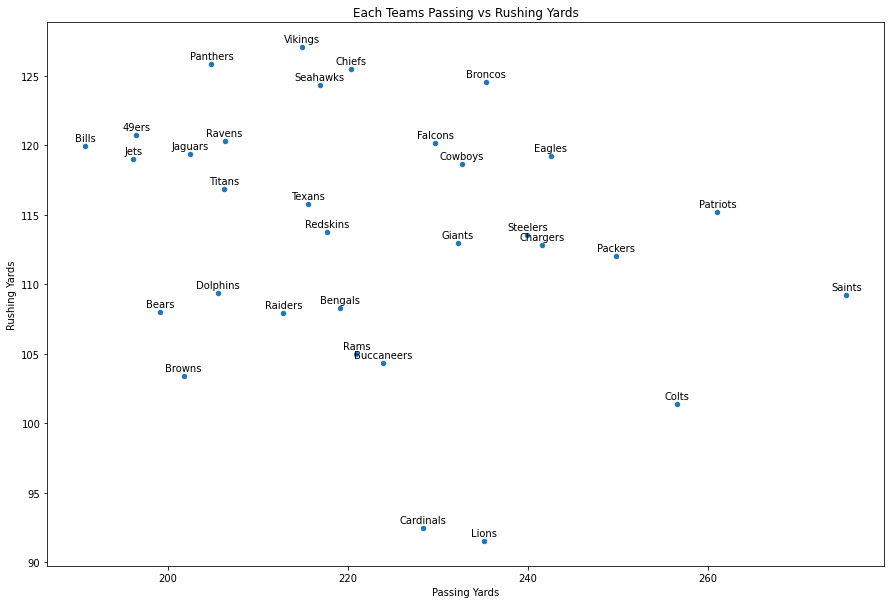

In [6]:
# Creating a plot dataframe to compare the average pass and rush yards for each team
plt_df = team_df[['team','passing_yards', 'rushing_yards']].groupby(by=['team']).mean()

# Creating a scatter plot of the passing yards versus rushing yards
ax = plt_df.plot.scatter('passing_yards', 'rushing_yards', figsize=(15,10))

# Adding a title and labeling the axis
ax.set(title=("Each Teams Passing vs Rushing Yards"), xlabel="Passing Yards", ylabel="Rushing Yards")

# Labeling the points with the team name
for team in plt_df.index:
  plt.annotate(team, (plt_df.at[team, 'passing_yards'], plt_df.at[team, 'rushing_yards']), 
               textcoords = 'offset points', xytext=(0,5), ha='center')

Based on the plot above, we can see that a couple of teams stand out for having high passing yards: Green Bay Packers, Indianapolis Colts, New England Patriots, New Orleans Saints. Looking at rushing yards, we can see that most teams have similar averages for rushing yards per game, with most teams having between 102 and 127 rushing yards per game. There are two teams who's rushing game is weak compared to the rest of the NFL. Both the Detroit Lions and the Arizona Cardinals are alone at the bottom of the graph, with about 93 rushing yards per game. It appears that in general, teams have about double the number of passing yards than rushing yards, and the number of rushing yards slightly decreases as the number of passing yards increases. 

Next, we will compare the ratio of rushing to passing yards with the average win percentage for each team to determine if the type of offensive method has any correlation with its chances of winning the game. 

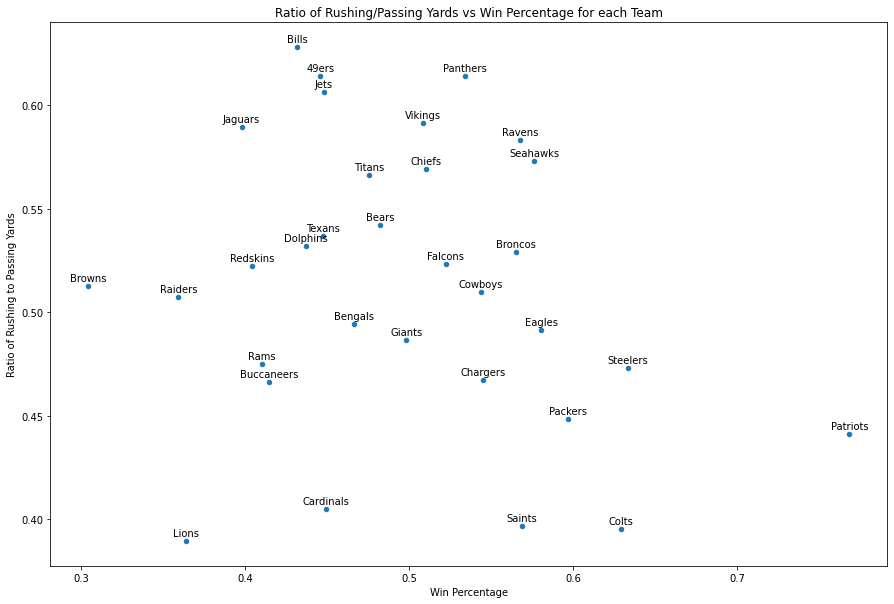

In [7]:
# Creating a plot dataframe to compare the ratio of rush to pass yards to win percentage for each team
plt_df = team_df[['team','passing_yards', 'rushing_yards', 'win_pct']].groupby(by=['team']).mean()
plt_df['yard_pct'] = plt_df['rushing_yards'] / plt_df['passing_yards']

# Creating a scatter plot of the yard ratio versus win percentage
ax = plt_df.plot.scatter('win_pct', 'yard_pct', figsize=(15,10))
# Adding a title and labeling the axis
ax.set(title=("Ratio of Rushing/Passing Yards vs Win Percentage for each Team"), 
       xlabel="Win Percentage", ylabel="Ratio of Rushing to Passing Yards")

# Labeling the points with the team name
for team in plt_df.index:
  plt.annotate(team, (plt_df.at[team, 'win_pct'], plt_df.at[team, 'yard_pct']), 
               textcoords = 'offset points', xytext=(0,5), ha='center')

We divided each team's average rushing yards by their passing yards to yield a ratio. We then plotted this ratio against win percentage. If a team has a lower ratio, that means that they rushed more than other teams, and if a team has a higher ratio, that means that they passed significantly more than other teams. However, because all ratios are less than 1, we can conclusively say that all teams passed more than they rushed. By looking at the scatter plot, we can see that there is no real correlation between win percentage and a team's ratio of rush to pass yards.

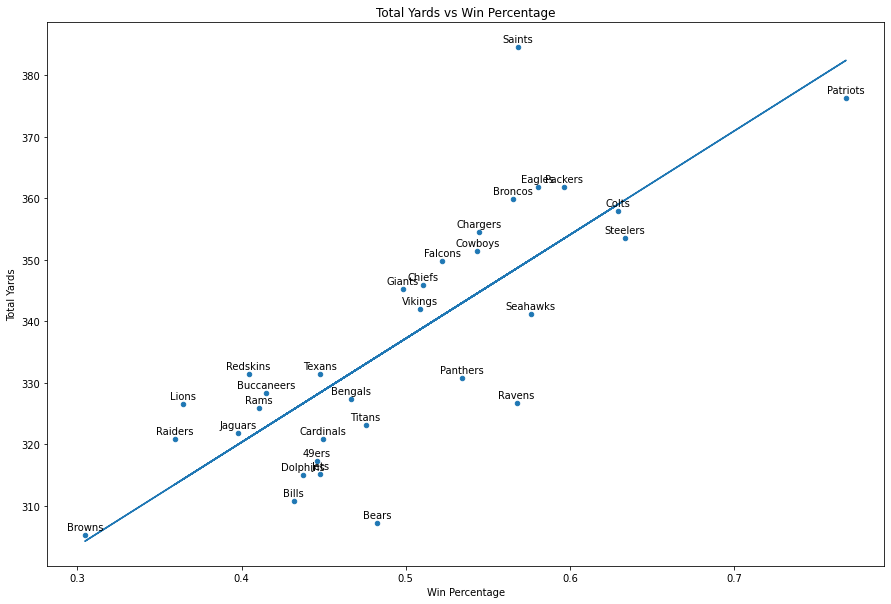

In [8]:
# Creating a plot dataframe to compare the total yards to win percentage for each team
plt_df = team_df[['team','total_yards', 'win_pct']].groupby(by=['team']).mean()

# Creating a scatter plot of total yards versus win percentage
ax = plt_df.plot.scatter('win_pct', 'total_yards', figsize=(15,10))
# Adding a title and labeling the axis
ax.set(title=("Total Yards vs Win Percentage"), xlabel="Win Percentage", ylabel="Total Yards")

# Adding a line of regression 
m, b = np.polyfit(plt_df['win_pct'], plt_df['total_yards'], 1)
plt.plot(plt_df['win_pct'], m*plt_df['win_pct'] + b)

# Labeling the points with the team name
for team in plt_df.index:
  plt.annotate(team, (plt_df.at[team, 'win_pct'], plt_df.at[team, 'total_yards']), 
               textcoords = 'offset points', xytext=(0,5), ha='center')

Now instead of looking at how the yards were gained, we are now looking at total yards. From the scatter plot of total yards vs win percentage, we can clearly see that there is a correlation. In general, it appears that teams that put up a higher number of yards per game seem to win more games. It doesn't matter whether these are rushing yards or passing yards, the teams with more yards win more.

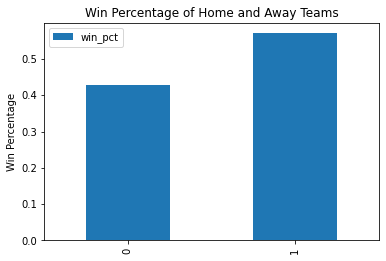

In [9]:
# Creating a bar graph of win percentage of home and away teams
ax = team_df[['home_or_away', 'win_pct']].groupby(by=['home_or_away']).mean().plot.bar()
# Adding a title and labeling the axis
ax.set(title=("Win Percentage of Home and Away Teams"), xlabel="", ylabel="Win Percentage")
plt.show()

Next, we wanted to see if where the game was played had an impact on the outcome. We averaged the win percentage for the home and away teams and plotted them on a bar graph. It appears that being the home team is a significant advantage, as the win percentage for the home team is almost 15% higher than the win percentage for the away team.

The next category we will look at is time of possession.

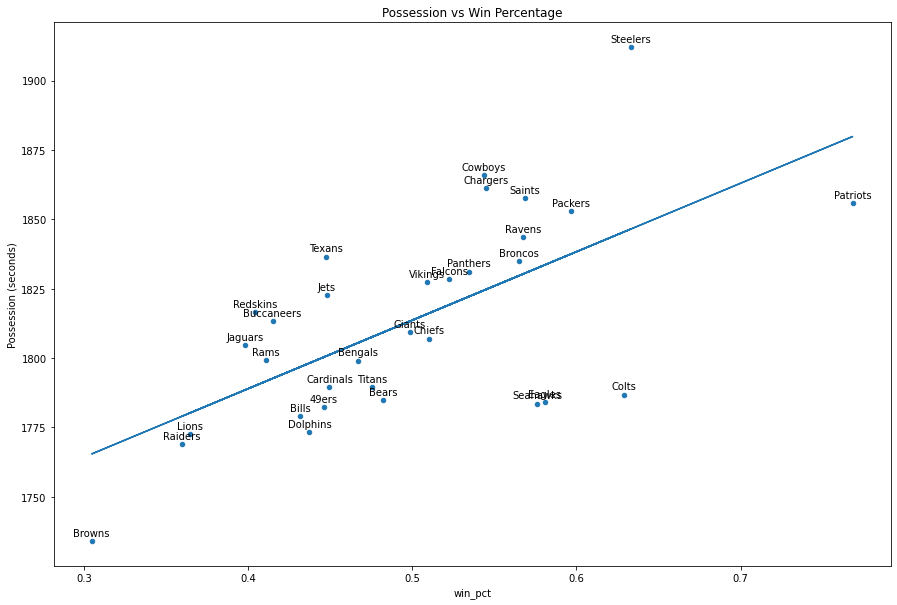

In [10]:
# Creating a plot dataframe to compare the possession to win percentage for each team
plt_df = team_df[['team','possession', 'win_pct']].groupby(by=['team']).mean()

# Creating a scatter plot of possession versus win percentage
ax = plt_df.plot.scatter('win_pct', 'possession', figsize=(15,10))
# Adding a title and labeling the axis
ax.set(title=("Possession vs Win Percentage"), xlabel="win_pct", ylabel="Possession (seconds)")

# Adding a line of regression 
m, b = np.polyfit(plt_df['win_pct'], plt_df['possession'], 1)
plt.plot(plt_df['win_pct'], m*plt_df['win_pct'] + b)

# Labeling the points with the team name
for team in plt_df.index:
  plt.annotate(team, (plt_df.at[team, 'win_pct'], plt_df.at[team, 'possession']), 
               textcoords = 'offset points', xytext=(0,5), ha='center')

Above is a chart comparing time of possession and win percentage. The scatter plot appears to have a linear trend, with a higher time of possession leading to a greater win percentage. We can see that while the trend is linear, this doesn't mean that the team with more possession will win. If we look at the Pittsburgh Steelers and the Indianapolis Colts, both teams have about the same win percentage, however the Colts have on average 2.25 minutes less  with the ball than the Steelers. One explanation for this lies within the rules of the game. An incomplete pass stops the clock, while any rush attempt continues to run down the clock. As we can see from the scatter plot of each team's Pass vs Rush yards, the Colts throw the ball more than the Steelers and the Steelers run the ball more than the Colts. Another reason could just be the efficiency of the offence. The faster the plays get called and the offence snaps the ball, the less overall time the team will have with the ball. Therefore if a team is more efficient at calling plays and lining up for the snap, they also may have less time with the ball despite putting up more points.

A different metric to look at to see who had more chances to score is the number of drives.

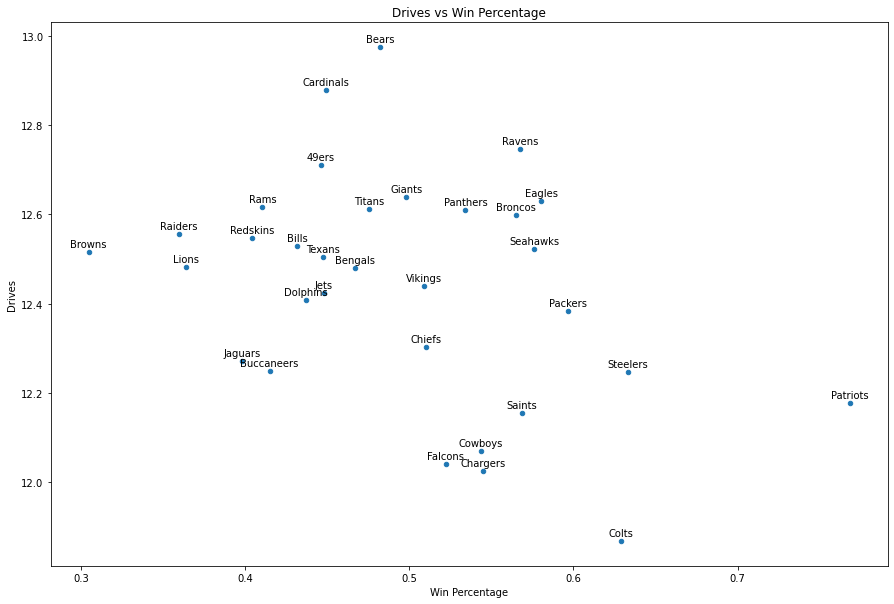

In [11]:
# Creating a plot dataframe to compare the number of drives to win percentage for each team
plt_df = team_df[['team','drives', 'win_pct']].groupby(by=['team']).mean()

# Creating a scatter plot of drives versus win percentage
ax = plt_df.plot.scatter('win_pct', 'drives', figsize=(15,10))
# Adding a title and labeling the axis
ax.set(title=("Drives vs Win Percentage"), xlabel="Win Percentage", ylabel="Drives")


# Labeling the points with the team name
for team in plt_df.index:
  plt.annotate(team, (plt_df.at[team, 'win_pct'], plt_df.at[team, 'drives']), 
               textcoords = 'offset points', xytext=(0,5), ha='center')

A drive is a consecutive series of plays by an offence. The reason this may be better to look at is because a team could have a 10 minute drive but have to settle for a field goal, while the other team could have two 5 minute drives, scoring a touchdown on both. In the scatter plot above, we can see that the number of drives doesn't really correlate to a teams win percentage.

In the last plot of this section, we will compare the average number of drives in the Redzone to a teams win percentage. 

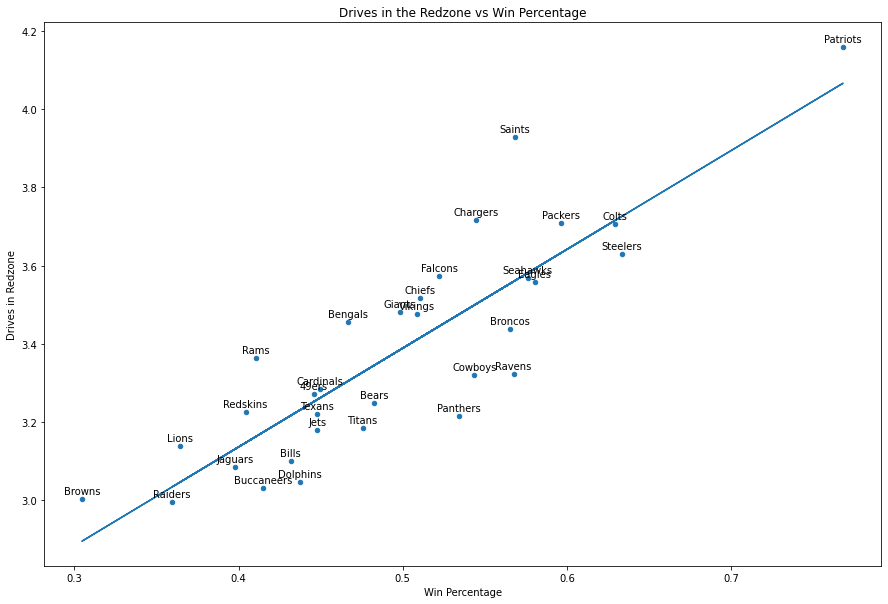

In [12]:
team_df['redzone_num'] = (team_df['redzone'].str.extract('-(\d+)', expand=False)).astype(float)
# Creating a plot dataframe to compare the redzone drives to win percentage for each team
plt_df = team_df[['team','redzone_num', 'win_pct']].groupby(by=['team']).mean()

# Creating a scatter plot of redzone drives versus win percentage
ax = plt_df.plot.scatter('win_pct', 'redzone_num', figsize=(15,10))
# Adding a title and labeling the axis
ax.set(title=("Drives in the Redzone vs Win Percentage"), xlabel="Win Percentage", ylabel="Drives in Redzone")

# Adding a line of regression 
m, b = np.polyfit(plt_df['win_pct'], plt_df['redzone_num'], 1)
plt.plot(plt_df['win_pct'], m*plt_df['win_pct'] + b)

# Labeling the points with the team name
for team in plt_df.index:
  plt.annotate(team, (plt_df.at[team, 'win_pct'], plt_df.at[team, 'redzone_num']), 
               textcoords = 'offset points', xytext=(0,5), ha='center')

One reason that there is no real correlation between drives and a team's win percentage is that a drive could end in a touchdown or a punt. Just because a team has more drives doesn't mean that they scored more points. That is why it is better to look at the number of redzone drives. The redzone is the section of the football field 20 yards from the endzone. If a drive reaches the redzone, it is highly likely that team scored from it. From the scatter plot of the number of redzone drives vs win percentage above, we can see that the more times a team drives the ball into the redzone, the more they will win.

## EDA (cont'd): Comparing Score Differentials

Other statistics, like sacks and completion percentage change drastically for each team from game to game. Therefore, we will compare these statistics on a game by game basis, instead of a teams' average. To accomplish this, we return to the original DataFrame from the CSV. The differentials between each away and home statistics is calculated and added as a new column to the dataframe. By subtracting the two values, we can see the net difference between the away vs home teams to see which team did better for each category. A negative number means that the home team had more of that category and a positive number means the away team had more of that category. If the number is 0, they have the same value for that category. For example, if the first downs for a game was -7, that would mean that the home team got 7 more first downs than the away team. The first 5 rows of the updated DataFrame are displayed to show the new additions to the dataset. 

In [13]:
data['first_downs'] = data['first_downs_away'] - data['first_downs_home']
data['third_downs_away_pct'] = (data['third_downs_away'].str.extract('(\d+)-', expand=False)).astype(float) / \
                               (data['third_downs_away'].str.extract('-(\d+)', expand=False)).astype(float)
data['third_downs_home_pct'] = (data['third_downs_home'].str.extract('(\d+)-', expand=False)).astype(float) / \
                               (data['third_downs_home'].str.extract('-(\d+)', expand=False)).astype(float)
data['third_down_pct'] = data['third_downs_away_pct'] - data['third_downs_home_pct']
data['pass_yards'] = data['passing_yards_away'] - data['passing_yards_home']
data['rush_yards'] = data['rushing_yards_away'] - data['rushing_yards_home']
data['total_yards'] = data['total_yards_away'] - data['total_yards_home']
data['comp_away_pct'] = (data['comp_att_away'].str.extract('(\d+)-', expand=False)).astype(float) / \
                        (data['comp_att_away'].str.extract('-(\d+)', expand=False)).astype(float)
data['comp_home_pct'] = (data['comp_att_home'].str.extract('(\d+)-', expand=False)).astype(float) / \
                        (data['comp_att_home'].str.extract('-(\d+)', expand=False)).astype(float)
data['comp_pct'] = data['comp_away_pct'] - data['comp_home_pct']
data['sacks_num'] = (data['sacks_away'].str.extract('(\d+)-', expand=False)).astype(int) - \
                    (data['sacks_home'].str.extract('(\d+)-', expand=False)).astype(int)
data['sacks_yards'] = (data['sacks_away'].str.extract('-(\d+)', expand=False)).astype(int) - \
                    (data['sacks_home'].str.extract('-(\d+)', expand=False)).astype(int)
data['rush_att'] = data['rushing_attempts_away'] - data['rushing_attempts_home']
data['fumble'] = data['fumbles_away'] - data['fumbles_home']
data['int'] = data['int_away'] - data['int_home']
data['turnovers'] = data['turnovers_away'] - data['turnovers_home']
data['num_penalty'] = (data['penalties_away'].str.extract('(\d+)-', expand=False)).astype(int) - \
                           (data['penalties_home'].str.extract('(\d+)-', expand=False)).astype(int)
data['penalty_yards'] = (data['penalties_away'].str.extract('-(\d+)', expand=False)).astype(int) - \
                            (data['penalties_home'].str.extract('-(\d+)', expand=False)).astype(int)
data['redzone_pct_away'] = (data['redzone_away'].str.extract('(\d+)-', expand=False)).astype(float) / \
                           (data['redzone_away'].str.extract('-(\d+)', expand=False)).astype(float)
data['redzone_pct_home'] = (data['redzone_home'].str.extract('(\d+)-', expand=False)).astype(float) / \
                           (data['redzone_home'].str.extract('-(\d+)', expand=False)).astype(float)
data['redzone_num'] = (data['redzone_away'].str.extract('-(\d+)', expand=False)).astype(float) - \
                      (data['redzone_home'].str.extract('-(\d+)', expand=False)).astype(float)
data['redzone_pct'] = data['redzone_pct_away'] - data['redzone_pct_home']
data['drives'] = data['drives_away'] - data['drives_home']
data['def_td_stands'] = data['def_st_td_away'] - data['def_st_td_home']
data['possession'] = data['top_away'] - data['top_home']
data['score'] = data['score_away'] - data['score_home']
data.head()

,date,away,home,first_downs_away,first_downs_home,third_downs_away,third_downs_home,fourth_downs_away,fourth_downs_home,passing_yards_away,passing_yards_home,rushing_yards_away,rushing_yards_home,total_yards_away,total_yards_home,comp_att_away,comp_att_home,sacks_away,sacks_home,rushing_attempts_away,rushing_attempts_home,fumbles_away,fumbles_home,int_away,int_home,turnovers_away,turnovers_home,penalties_away,penalties_home,redzone_away,redzone_home,drives_away,drives_home,def_st_td_away,def_st_td_home,possession_away,possession_home,score_away,score_home,top_away,top_home,first_downs,third_downs_away_pct,third_downs_home_pct,third_down_pct,pass_yards,rush_yards,total_yards,comp_away_pct,comp_home_pct,comp_pct,sacks_num,sacks_yards,rush_att,fumble,int,turnovers,num_penalty,penalty_yards,redzone_pct_away,redzone_pct_home,redzone_num,redzone_pct,drives,def_td_stands,possession,score
0,2002-09-05,49ers,Giants,13,21,4-12,9-16,0-0,0-1,166,318,113,43,279,361,16-26,28-45,0-0,3-24,25,22,0,0,1,3,1,3,5-29,10-80,0-8,0-6,13,15,0,0,27:32,32:28,16,13,1652,1948,-8,0.333333,0.562500,-0.229167,-152,70,-82,0.615385,0.622222,-0.006838,-3,-24,3,0,-2,-2,-5,-51,0.0,0.0,2.0,0.0,-2,0,-296,3
1,2002-09-08,Jets,Bills,18,26,2-8,7-17,0-0,2-2,193,242,73,142,266,384,24-30,26-39,3-17,4-29,14,32,1,1,0,2,1,3,10-90,10-82,0-9,0-8,17,18,2,0,21:06,39:08,37,31,1266,2348,-8,0.250000,0.411765,-0.161765,-49,-69,-118,0.800000,0.666667,0.133333,-1,-12,-18,0,-2,-2,0,8,0.0,0.0,1.0,0.0,-1,2,-1082,6
2,2002-09-08,Vikings,Bears,19,20,5-13,7-13,0-0,0-0,228,288,140,80,368,368,16-28,20-33,1-6,1-9,33,26,1,1,2,1,3,2,8-52,4-33,0-7,0-6,17,17,0,0,31:31,28:29,23,27,1891,1709,-1,0.384615,0.538462,-0.153846,-60,60,0,0.571429,0.606061,-0.034632,0,-3,7,0,1,1,4,19,0.0,0.0,1.0,0.0,0,0,182,-4
3,2002-09-08,Chargers,Bengals,27,13,6-10,4-11,0-0,0-0,160,167,241,36,401,203,15-19,18-31,1-0,4-31,45,13,0,0,0,1,0,1,4-39,9-57,0-7,0-5,11,15,0,0,37:48,22:12,34,6,2268,1332,14,0.600000,0.363636,0.236364,-7,205,198,0.789474,0.580645,0.208829,-3,-31,32,0,-1,-1,-5,-18,0.0,0.0,2.0,0.0,-4,0,936,28
4,2002-09-08,Chiefs,Browns,24,24,5-11,4-11,0-0,0-0,276,352,194,59,470,411,20-29,28-40,0-0,1-7,30,20,0,1,1,0,1,1,9-87,4-38,0-10,0-10,20,17,0,0,30:16,29:44,40,39,1816,1784,0,0.454545,0.363636,0.090909,-76,135,59,0.689655,0.700000,-0.010345,-1,-7,10,-1,1,0,5,49,0.0,0.0,0.0,0.0,3,0,32,1


The last step in this data manipulation will be discarding the unnecessary columns and renaming the remaining columns.

In [14]:
data = data[['first_downs', 'third_down_pct', 'pass_yards', 'rush_yards', 'total_yards', 'comp_pct', 'sacks_num', 
             'sacks_yards', 'rush_att', 'fumble', 'int', 'turnovers', 'num_penalty', 'penalty_yards', 
             'redzone_pct', 'redzone_num', 'drives', 'def_td_stands', 'possession', 'score']]
data.head()

,first_downs,third_down_pct,pass_yards,rush_yards,total_yards,comp_pct,sacks_num,sacks_yards,rush_att,fumble,int,turnovers,num_penalty,penalty_yards,redzone_pct,redzone_num,drives,def_td_stands,possession,score
0,-8,-0.229167,-152,70,-82,-0.006838,-3,-24,3,0,-2,-2,-5,-51,0.0,2.0,-2,0,-296,3
1,-8,-0.161765,-49,-69,-118,0.133333,-1,-12,-18,0,-2,-2,0,8,0.0,1.0,-1,2,-1082,6
2,-1,-0.153846,-60,60,0,-0.034632,0,-3,7,0,1,1,4,19,0.0,1.0,0,0,182,-4
3,14,0.236364,-7,205,198,0.208829,-3,-31,32,0,-1,-1,-5,-18,0.0,2.0,-4,0,936,28
4,0,0.090909,-76,135,59,-0.010345,-1,-7,10,-1,1,0,5,49,0.0,0.0,3,0,32,1


To get a better understanding of these newly calculated statistics, we will begin by graphing a violin plot of the number of sacks and the game score differential. 

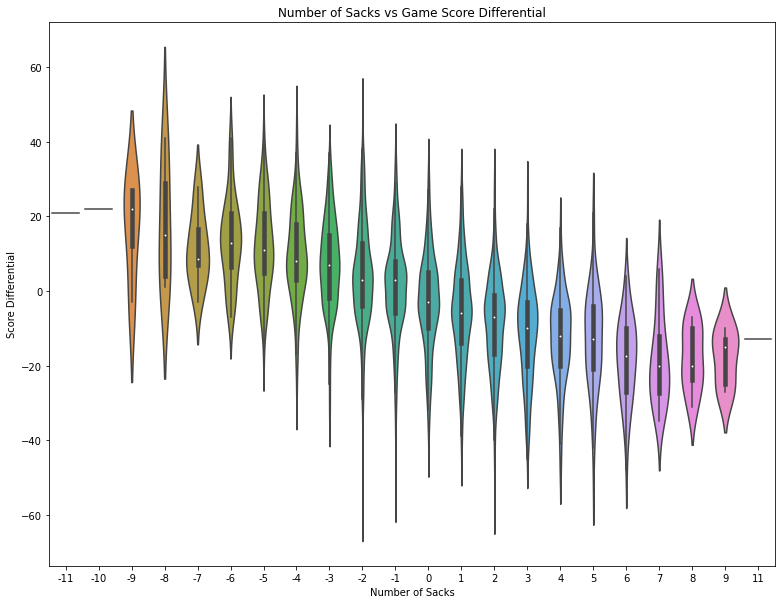

In [15]:
f, ax = plt.subplots(figsize=(13,10))
# Creating a violin plot of Number of Sacks vs Game Score Differential
ax = sns.violinplot(x='sacks_num', y='score', data=data,)
# Adding a title and labeling the axis
ax.set(title=("Number of Sacks vs Game Score Differential"), xlabel="Number of Sacks", ylabel="Score Differential")
plt.show()

Based on the downward linear trend of the plot (in both the median value and individual violin bars), we can see that as the number of sacks deviates from zero (positive or negative value doesn't matter because differentials are recorded), the score differential increases too (again, positive or negative doesn't matter because differentials are recorded). This means that the more times a team's quarterback is sacked (i.e. the greater the variation from 0), the less points the team scores. This technique of graphing differentials is continued throughout the rest of the section.

Next, we will compare the sack yards to the game score differential. 

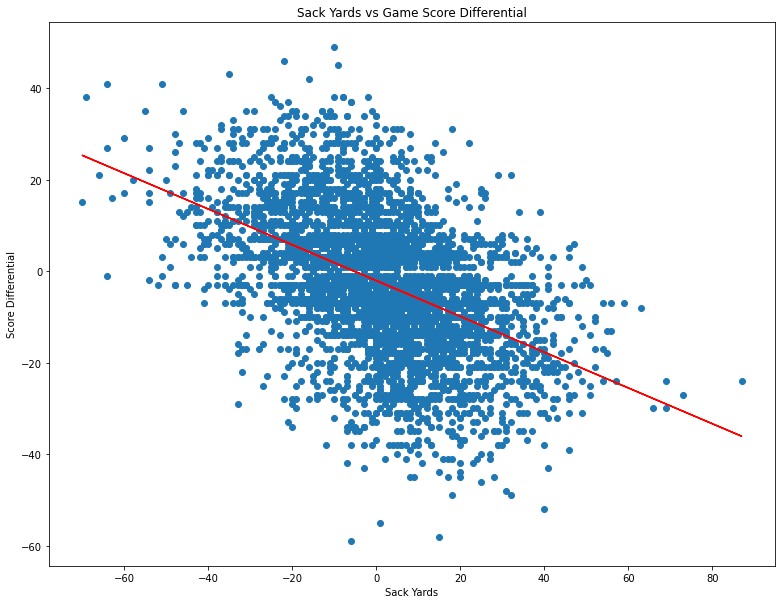

In [16]:
f, ax = plt.subplots(figsize=(13,10))
# Creating a scatter plot of Sack Yards vs Game Score Differential
ax = plt.scatter(data['sacks_yards'], data['score'])

# Adding a line of regression 
m, b = np.polyfit(data['sacks_yards'], data['score'], 1)
plt.plot(data['sacks_yards'], m*data['sacks_yards'] + b, c='r')

# Adding a title and labeling the axis
plt.title("Sack Yards vs Game Score Differential")
plt.xlabel("Sack Yards")
plt.ylabel("Score Differential")
plt.show()


Another component of sacks is how much yardage they lost from their quarterback being sacked. Here we can see that there is a linear relationship between the sack yardage and the score of the game, based on the red line of regression drawn above. Like the number of sacks graph that we plotted above, the more sack yardage a team has, the less points they score

We will also plot the first downs and game score differentials. 

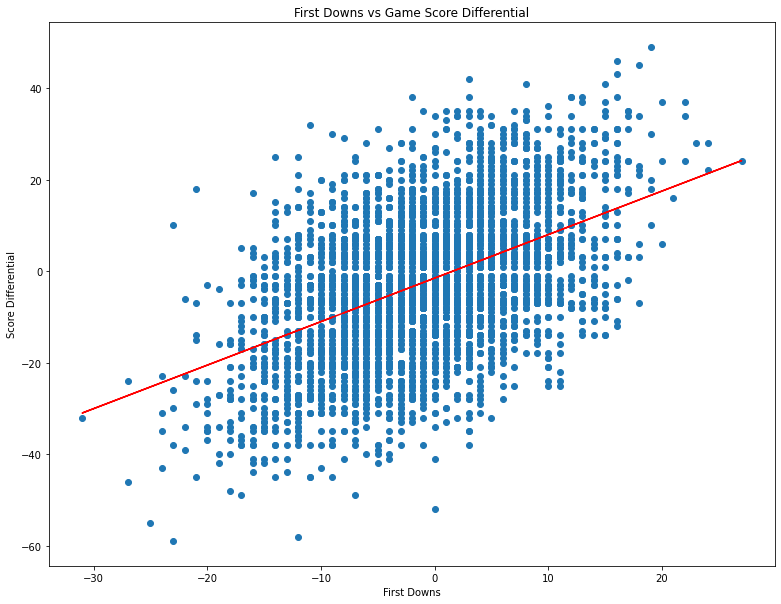

In [17]:
f, ax = plt.subplots(figsize=(13,10))
# Creating a scatter plot of First Downs vs Game Score Differential
ax = plt.scatter(data['first_downs'], data['score'])

# Adding a line of regression 
m, b = np.polyfit(data['first_downs'], data['score'], 1)
plt.plot(data['first_downs'], m*data['first_downs'] + b, c='r')

# Adding a title and labeling the axis
plt.title("First Downs vs Game Score Differential")
plt.xlabel("First Downs")
plt.ylabel("Score Differential")
plt.show()

We can also see a linear relationship between the number of first downs and the score of the game. The more first downs a team has, the more they are advancing the ball across the field which gives them a better chance to score. Therefore it seems reasonable to assume that the number of first downs a team accumulates factors into their score.

Now, we will plot third down percentage and game score differential. 

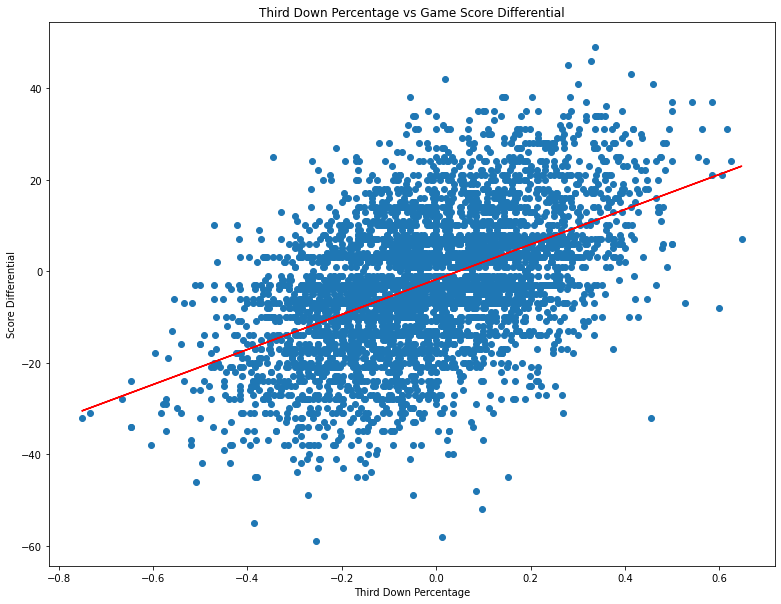

In [18]:
f, ax = plt.subplots(figsize=(13,10))
# Creating a scatter plot of Third Down Percentage vs Game Score Differential
ax = plt.scatter(data['third_down_pct'], data['score'])

# Adding a line of regression 
m, b = np.polyfit(data['third_down_pct'], data['score'], 1)
plt.plot(data['third_down_pct'], m*data['third_down_pct'] + b, c='r')

# Adding a title and labeling the axis
plt.title("Third Down Percentage vs Game Score Differential")
plt.xlabel("Third Down Percentage")
plt.ylabel("Score Differential")
plt.show()

Above, we can see that there is a linear relationship between third down conversion percentage and the score of a game. Third downs are crucial to continue a drive and be able to score. If a team does not convert on third down, they either have to punt the ball away or settle for a 3-point field goal. If they get the first down, they are able to continue the drive and possibly get a field goal or a touchdown. Based on the plot above, we see that the more third downs  a team completes, the more points they score. 

Below, we will calculate the completion percentage and game score differential. 

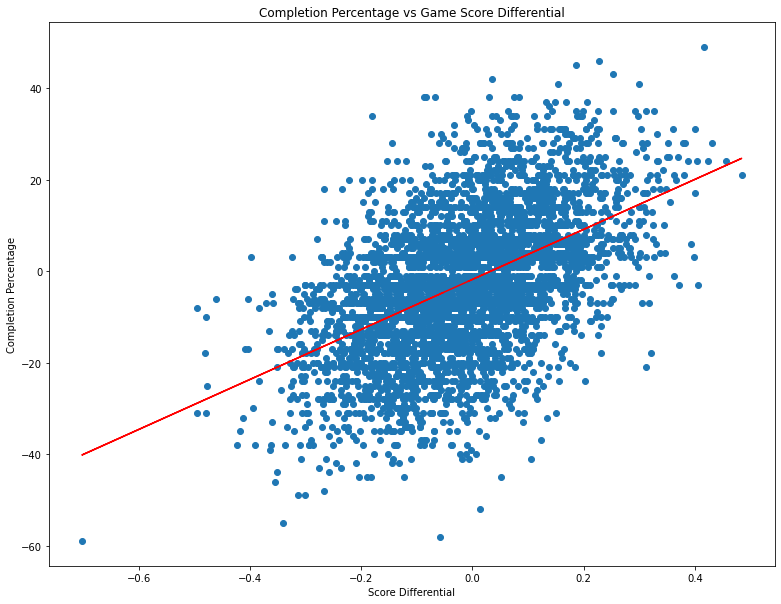

In [19]:
f, ax = plt.subplots(figsize=(13,10))
# Creating a scatter plot of Completion Percentage vs Game Score Differential
ax = plt.scatter(data['comp_pct'], data['score'])

# Adding a line of regression 
m, b = np.polyfit(data['comp_pct'], data['score'], 1)
plt.plot(data['comp_pct'], m*data['comp_pct'] + b, c='r')

# Adding a title and labeling the axis
plt.title("Completion Percentage vs Game Score Differential")
plt.xlabel("Score Differential")
plt.ylabel("Completion Percentage")
plt.show()

Here, we can see that there is a linear relationship between completion percentage and the score of the game. If a quarterback is completing more passes than the other team, they will accumulate more yardage and score more points. If a quarterback is throwing incomplete passes, it wastes downs and makes it more likely that they will have to punt the ball.

Finally, we will plot the relationship bewteen turnovers and the game score differential. 

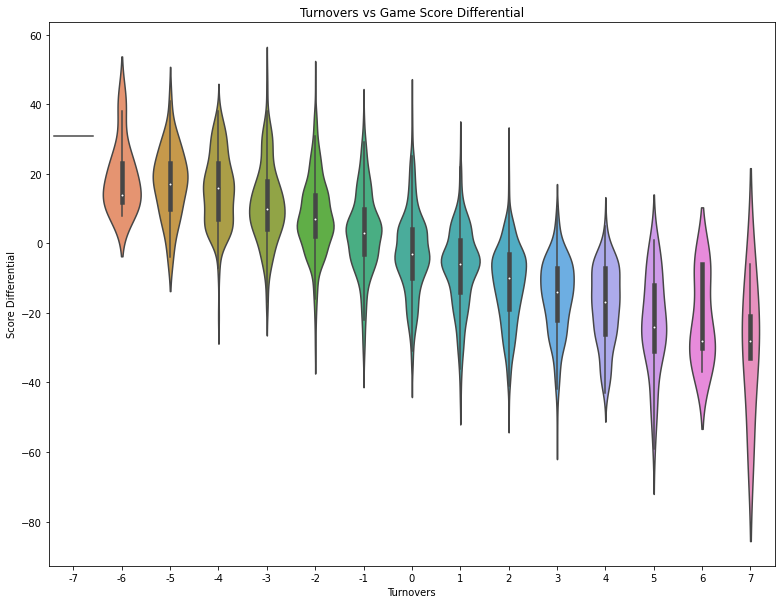

In [20]:
f, ax = plt.subplots(figsize=(13,10))
# Creating a violin plot of Turnovers vs Game Score Differential
ax = sns.violinplot(x='turnovers', y='score', data=data)
# Adding a title and labeling the axis
ax.set(title=("Turnovers vs Game Score Differential"), xlabel="Turnovers", ylabel="Score Differential")
plt.show()

Lastly, we see that the number of turnovers a team gives up also has a linear relationship with the score (based on the decreasing median value and individual violin bar). Turning over the ball gives away your team's chance to score and gives the other team possession and the possibility of scoring. Therefore, the more turnovers your team has, the more the other team will beat you by.

# Using a Model to Predict Scores
Now that we have established which statistics have a relationship with the score of the game, we will use these to fit a model. We will then use this model to try and predict a team's score to see how close we come to the actual score. 

### Looking at an individual teams performance
We will return to the team DataFrame that has split up each game into seperate teams. Some of the entries are in the form "x-y", like completions, third downs, and redzone percentage, so we are separating the numbers into a percentage or into different columns. To calculate the percentages, we divided x/y. 

In [21]:
team_df['third_down_pct'] = (team_df['third_downs'].str.extract('(\d+)-', expand=False)).astype(float) / \
                               (team_df['third_downs'].str.extract('-(\d+)', expand=False)).astype(float)
team_df['comp_pct'] = (team_df['completions'].str.extract('(\d+)-', expand=False)).astype(float) / \
                        (team_df['completions'].str.extract('-(\d+)', expand=False)).astype(float)
team_df['sacks_num'] = (team_df['sacks'].str.extract('(\d+)-', expand=False)).astype(int)
team_df['sacks_yards'] = (team_df['sacks'].str.extract('-(\d+)', expand=False)).astype(int)
team_df['num_penalty'] = (team_df['penalties'].str.extract('(\d+)-', expand=False)).astype(int)
team_df['penalty_yards'] = (team_df['penalties'].str.extract('-(\d+)', expand=False)).astype(int)
team_df['redzone_pct'] = (team_df['redzone'].str.extract('(\d+)-', expand=False)).astype(float) / \
                           (team_df['redzone'].str.extract('-(\d+)', expand=False)).astype(float)
team_df['redzone_num'] = (team_df['redzone'].str.extract('-(\d+)', expand=False)).astype(float)
team_df = team_df[['home_or_away', 'first_downs', 'third_down_pct', 'passing_yards', 'rushing_yards', 'total_yards', 
                   'comp_pct', 'sacks_num', 'sacks_yards',  'rushing_attempts', 'fumbles', 'interceptions', 
                   'turnovers', 'num_penalty', 'penalty_yards', 'redzone_pct', 'redzone_num', 'drives', 'def_st_td', 
                   'possession', 'score', 'win_pct']]
team_df.head()

,home_or_away,first_downs,third_down_pct,passing_yards,rushing_yards,total_yards,comp_pct,sacks_num,sacks_yards,rushing_attempts,fumbles,interceptions,turnovers,num_penalty,penalty_yards,redzone_pct,redzone_num,drives,def_st_td,possession,score,win_pct
0,1,21,0.562500,318,43,361,0.622222,3,24,22,0,3,3,10,80,0.0,6.0,15,0,1948,13,0
1,0,13,0.333333,166,113,279,0.615385,0,0,25,0,1,1,5,29,0.0,8.0,13,0,1652,16,1
2,1,26,0.411765,242,142,384,0.666667,4,29,32,1,2,3,10,82,0.0,8.0,18,0,2348,31,0
3,0,18,0.250000,193,73,266,0.800000,3,17,14,1,0,1,10,90,0.0,9.0,17,2,1266,37,1
4,1,20,0.538462,288,80,368,0.606061,1,9,26,1,1,2,4,33,0.0,6.0,17,0,1709,27,1


Next, we will replace all NaNs with a 0 because they were created when we tried to divide 0/0 when extracting data from a column. We will also create the training data (X) based on the factors that go into determining the outcome of a game, and assign y to be what we would like to find the outcome of (score of the game). 

In [22]:
team_df = team_df.replace(np.NaN, 0.0)
X = team_df[['home_or_away', 'first_downs', 'third_down_pct', 'passing_yards', 'rushing_yards', 'total_yards', 
             'comp_pct', 'sacks_num', 'sacks_yards',  'rushing_attempts', 'fumbles', 'interceptions', 
             'turnovers', 'num_penalty', 'penalty_yards', 'redzone_pct', 'redzone_num', 'drives', 'def_st_td', 
             'possession']]
y = team_df['score']
X

,home_or_away,first_downs,third_down_pct,passing_yards,rushing_yards,total_yards,comp_pct,sacks_num,sacks_yards,rushing_attempts,fumbles,interceptions,turnovers,num_penalty,penalty_yards,redzone_pct,redzone_num,drives,def_st_td,possession
0,1,21,0.562500,318,43,361,0.622222,3,24,22,0,3,3,10,80,0.000000,6.0,15,0,1948
1,0,13,0.333333,166,113,279,0.615385,0,0,25,0,1,1,5,29,0.000000,8.0,13,0,1652
2,1,26,0.411765,242,142,384,0.666667,4,29,32,1,2,3,10,82,0.000000,8.0,18,0,2348
3,0,18,0.250000,193,73,266,0.800000,3,17,14,1,0,1,10,90,0.000000,9.0,17,2,1266
4,1,20,0.538462,288,80,368,0.606061,1,9,26,1,1,2,4,33,0.000000,6.0,17,0,1709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9251,0,26,0.588235,270,129,399,0.700000,1,8,34,0,0,0,9,68,0.500000,4.0,10,0,1923
9252,1,23,0.583333,316,32,348,0.590909,1,4,14,1,2,3,8,74,0.666667,3.0,10,0,1555
9253,0,18,0.615385,132,124,256,0.750000,0,0,36,0,1,1,6,45,0.333333,3.0,10,2,2045
9254,1,22,0.333333,277,170,447,0.615385,1,6,29,2,1,3,6,48,0.250000,4.0,10,0,1984


Here we will use the Linear Regression Model from sklearn to predict the scores. First we split the data into test and train data. From the DataFrame, 80% will be used to train the data, then we will use that trained model to predict the scores of the other 20%. 

In [23]:
from sklearn import linear_model
# Creating a linear regression model
clf = linear_model.LinearRegression()

from sklearn.model_selection import train_test_split
# Splitting the data up 80%-20% for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

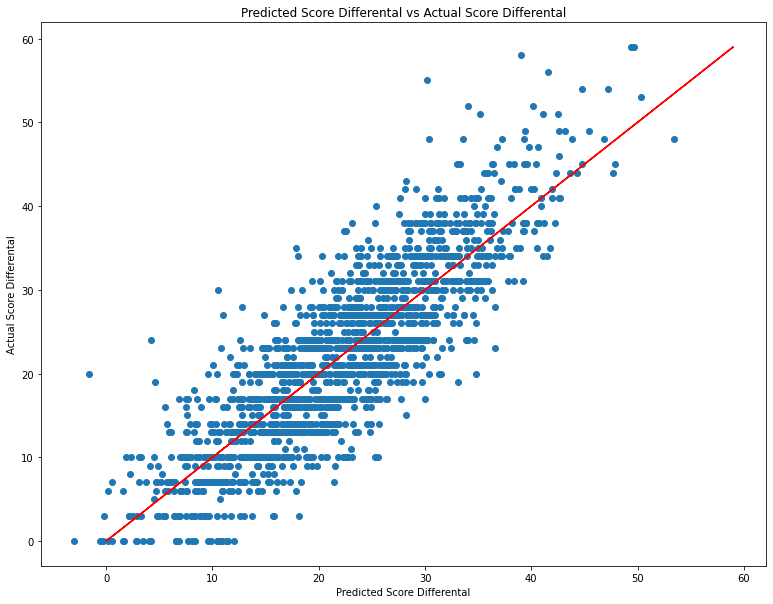

In [24]:
f, ax = plt.subplots(figsize=(13,10))
# Creating a scatter plot of Predicted Score Differental vs Actual Score Differental
ax = plt.scatter(pred, y_test)

# Adding a line of y=x
plt.plot(y_test, y_test, color="Red")

# Adding a title and labeling the axis
plt.title("Predicted Score Differental vs Actual Score Differental")
plt.xlabel("Predicted Score Differental")
plt.ylabel("Actual Score Differental")
plt.show()


The red line of y=x shows what the scatterplot would look like if every predicted score was 100% accurate and matched up with the actual score. In the scatter plot above, we can see that the predicted score differential is generally close to the actual score line. This means that the Linear Regression model we generated predicts scores fairly accurately, in comparison to the actual score differentials. 

In [25]:
clf.score(X,y)

0.7177183647176905

Above is the R-squared score for our predicted model. The value of 0.71 indicates that the model explains 71% of the variability of the data. This confirms our observation from the scatter plot that the model was fairly accurate at predicting a teams final score.

Next, we will see which attributes most impact the score of a game. 

In [26]:
attrs = ['home_or_away', 'first_downs', 'third_down_pct', 'passing_yards', 'rushing_yards', 'total_yards', 'comp_pct',
         'sacks_num', 'sacks_yards',  'rushing_attempts', 'fumbles', 'interceptions', 'turnovers', 'num_penalty',
         'penalty_yards', 'redzone_pct', 'redzone_num', 'drives', 'def_st_td', 'possession']
coeffs = clf.coef_.tolist()
for attr, coef in zip(attrs, coeffs):
    print("Attribute: {:18s} Coefficient: {:.2f}".format(attr,coef))

Attribute: home_or_away       Coefficient: 0.68
Attribute: first_downs        Coefficient: 0.33
Attribute: third_down_pct     Coefficient: 6.83
Attribute: passing_yards      Coefficient: 0.02
Attribute: rushing_yards      Coefficient: 0.01
Attribute: total_yards        Coefficient: 0.03
Attribute: comp_pct           Coefficient: 13.49
Attribute: sacks_num          Coefficient: -0.28
Attribute: sacks_yards        Coefficient: 0.02
Attribute: rushing_attempts   Coefficient: 0.35
Attribute: fumbles            Coefficient: -0.58
Attribute: interceptions      Coefficient: -0.51
Attribute: turnovers          Coefficient: -1.10
Attribute: num_penalty        Coefficient: -0.05
Attribute: penalty_yards      Coefficient: -0.00
Attribute: redzone_pct        Coefficient: 5.38
Attribute: redzone_num        Coefficient: 0.52
Attribute: drives             Coefficient: 0.73
Attribute: def_st_td          Coefficient: 3.90
Attribute: possession         Coefficient: -0.01


Based on the coefficients of our attributes, we see slight home field advantage. The completion percentage (comp_pct), third down conversion (third_down_pct), and scoring touchdowns in the redzone (redzone_pct) are the top three most important factors, respectively, when predicting the score. Defence's stopping redzone touchdowns (def_st_td) also important. We can also see the negative impact of turnovers, sacks, fumbles, and interceptions. 

In [27]:
df = pd.DataFrame({'Predicted':pred, 'Actual':y_test})
df['residual'] = abs(df['Predicted'] - df['Actual'])
df['residual'].mean()

4.322577152717631

Above, we calculated the average of the residual, or by how far the predicted score is off. We can see that linear regression is off by an average of about 4.3 points, which is 1.3 points more than a field goal and 2.7 points less than a touchdown. In the grand scheme of the game, this variance is less than a one score difference. This just goes to show that our model is pretty accurate if the residual score value is within a one score difference. 

Next, we will plot the density of the residual values calculated from finding the difference between the predicted and actual score values. 

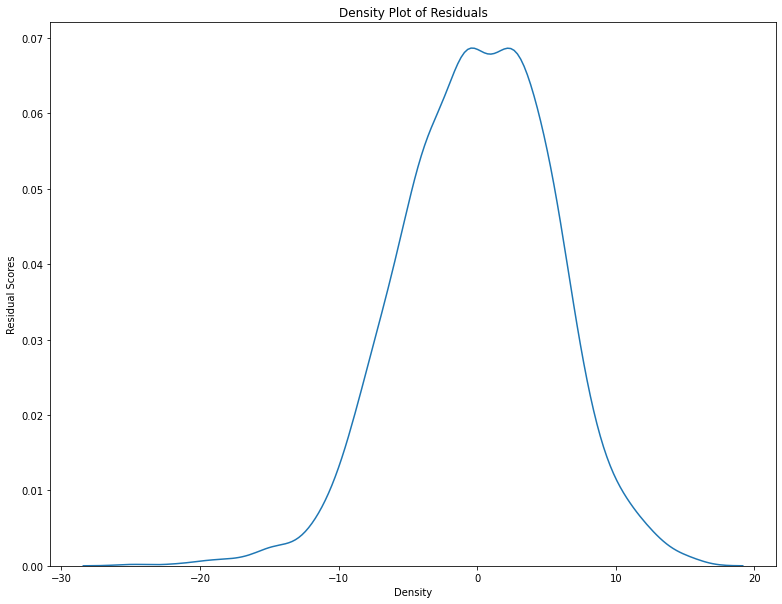

In [28]:
df = pd.DataFrame({'Predicted':pred, 'Actual':y_test})
df['residual'] = df['Predicted'] - df['Actual']
f, ax = plt.subplots(figsize=(13,10))

# Creating a density plot of residuals
ax = sns.kdeplot(df['residual'], label="Residual")

# Adding a title and labeling the axis
ax.set(title=("Density Plot of Residuals"), xlabel="Density", ylabel="Residual Scores")
plt.show()

Looking at the density plot above, we see that the graph is centered around a mean of zero, with most of the residual scores being between -10 and 10. This shows that almost all of the models predictions were off by less than 10 points.

### Looking at both teams performances
Our model up to this point has been based on the individual teams and games played between the 2002-2019 seasons. This data from the team_df dataframe is all of the information that we analyzed in the first EDA section. Now, we will return to the original dataframe, data, that stores all of the differential statistics, as extracted from the CSV. This dataframe was analyzed in the second EDA section, when comparing score differentials. Using the origianl dataframe, data, we will try to predict the score of games based on two teams stats with the differentials.

In [29]:
data = data.replace(np.NaN, 0.0)
X = data[['first_downs', 'third_down_pct', 'pass_yards', 'rush_yards', 'total_yards', 'comp_pct', 'sacks_num', 
          'sacks_yards',  'rush_att', 'fumble', 'int', 'turnovers', 'num_penalty', 'penalty_yards', 'redzone_pct', 
          'redzone_num', 'drives', 'def_td_stands', 'possession']]
y = data['score']


Again, we will use the Linear Regression Model from sklearn to predict the scores. First we split the data into test and train data. From the data set, 80% will be used to train the data and 20% will be used to test the data. 

In [30]:
clf = linear_model.LinearRegression()

# Splitting the data up 80%-20% for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

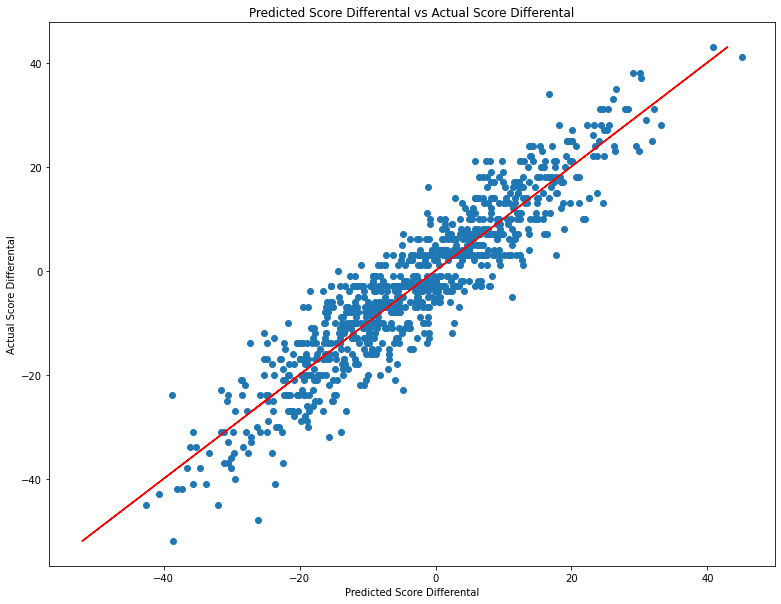

In [31]:
f, ax = plt.subplots(figsize=(13,10))
# Creating a scatter plot of Predicted Score Differental vs Actual Score Differental
ax = plt.scatter(pred, y_test)

# Adding a line of y=x
plt.plot(y_test, y_test, color="Red")

# Adding a title and labeling the axis
plt.title("Predicted Score Differental vs Actual Score Differental")
plt.xlabel("Predicted Score Differental")
plt.ylabel("Actual Score Differental")
plt.show()


Once again, the red y=x line shows what a 100% accurate model would look like, where every predicted value equals an actual score value. Based on the fact that many of the points closely hover this y=x line, we can see that our model is pretty accurate. 

In [32]:
clf.score(X,y)

0.842981166717688

The high R-squared shows that about 85% of the variability of the data is explained by the model. This is an improvement from modelling with the team_df that simply uses raw numbers, rather than differentials. 

In [33]:
df = pd.DataFrame({'Predicted':pred, 'Actual':y_test})
df['residual'] = abs(df['Predicted'] - df['Actual'])
df['residual'].mean()

4.648256589120165

The average of the residual values calculated above predicts the difference in our model's score and actual score to be about 4.6 points. Similar to the average residual value calculated earlier, the 4.6 represents how much our predicted score is off by. In football terms, 4.6 points is less than a one score difference. This is another sign that our model is pretty accurate. 

In [34]:
df['w'] = ((df['Actual']>0) & (df['Predicted']>0) | (df['Actual']<0) & (df['Predicted']<0) | 
           (df['Actual']==0) & (df['Predicted']==0)).astype(int)
df['w'].mean()

0.8920086393088553

Additionally, the margin of victory doesn't matter to a team's record, only wins and losses. Here, we want to see how often the model predicts the winner of a game. We can calulate this by seeing if both actual and predicted values are greater than 0 (accurately predicted away team won), if both actual and predicted values are less than 0 (accurately predicted home team won), and if the actual value is the same as the predicted value. Using linear regression, it predicts the winner correctly about 90% of the time.

Lastly, we will plot the density of the residuals. 

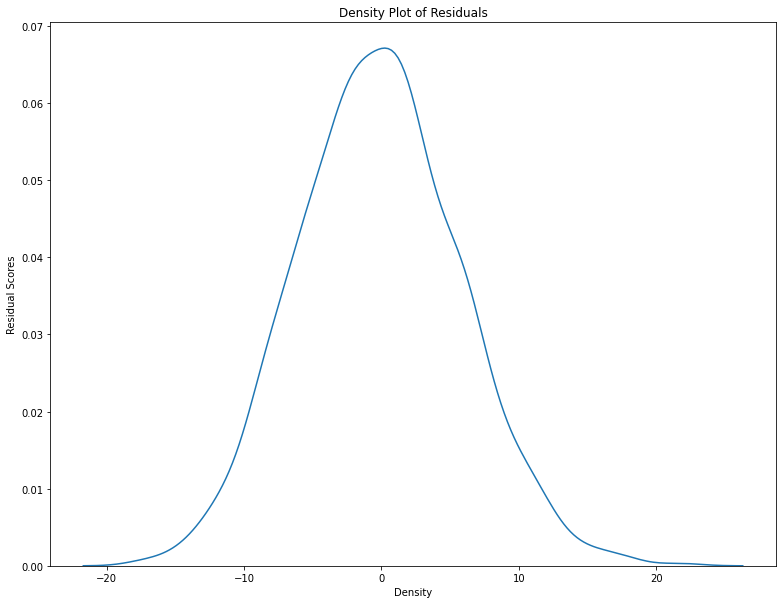

In [35]:
df = pd.DataFrame({'Predicted':pred, 'Actual':y_test})
df['residual'] = df['Predicted'] - df['Actual']
f, ax = plt.subplots(figsize=(13,10))

# Creating a density plot of residuals
ax = sns.kdeplot(df['residual'], label="Residual")

# Adding a title and labeling the axis
ax.set(title=("Density Plot of Residuals"), xlabel="Density", ylabel="Residual Scores")
plt.show()

Looking at the density plot, we again see that the graph is centered around a zero mean with most of the residuals being between -10 and 10. Again, this shows that almost all of the models predictions were off by 10 points or less.

# Conclusion

In conclusion, we can see that specific statistics of a game heavily impact the outcome and score. Home field advantage, total yardage, time of possession, number of drives in the redzone, first down count, third down completion percentage, and overall completion percentage all have a positive linear relationship with the score of a game. Having high values in those categories can increase a team's chances of winning the game. In contrast, the number of sacks, total sack yardage, and turnovers all have a negative linear relationship with the score of the game. The higher the values in these categories, the more likely a team is to lose. Lastly, based on the modeling predictors, we were able to determine that the three categories with the greatest influence in predicting the score of a game was completion percentage, third down percentage, and red zone percentage. 

Our goal with this tutorial was to provide a better understanding on what goes into determining the outcome of an NFL game. While the data used for this tutorial is from the 2002-2019 seasons, we hope it gives fans a better intution of the game, whether it be for picking players for fantasy teams, or predicting which team has better chances of winning. 